In [ ]:
#pip install pyathena

In [2]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np

In [3]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
table_name = 'ventas_mensuales'

In [4]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)

/opt/conda/lib/python3.10/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df

,payer,country,date,amount
0,BANCO DE CREDITO DEL PERU - BCP (UT),PERU,2021-12-05,23150.00
1,GME,NEPAL,2023-08-11,6486.00
2,COOPERATIVA FRONTERIZA (UT),HONDURAS,2023-09-23,33632.00
3,DAVIVIENDA - HONDURAS (BTS),HONDURAS,2023-09-24,14824.50
4,GLOBAL ENVIOS,ECUADOR,2022-03-29,29563.00
...,...,...,...,...
103721,PROMERICA (GUA),GUATEMALA,2021-07-13,10855.00
103722,WALMART (UT),MEXICO,2021-07-15,138935.54
103723,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2021-07-15,22438.00
103724,CUSCA (CITI - RECIBA NETWORKS),EL SALVADOR,2023-06-01,239445.00


In [6]:
df.describe()

,amount
count,1.037260e+05
mean,2.420666e+05
std,8.518851e+05
min,-4.485863e+05
25%,2.180000e+03
50%,2.560756e+04
75%,1.399608e+05
max,1.398802e+07


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103726 entries, 0 to 103725
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   payer    103726 non-null  object 
 1   country  103726 non-null  object 
 2   date     103726 non-null  object 
 3   amount   103726 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.2+ MB


In [8]:
# Date has not datetime format
df['date'] = pd.to_datetime(df['date'])

In [9]:
df.nunique()

payer        241
country       82
date        1025
amount     78570
dtype: int64

In [10]:
#Excluding 'amount' == 0
df = df[df.amount!=0]

In [11]:
#Excluding 'EXPIRED ORDERS'
df = df[df['payer']!='EXPIRED ORDERS']

In [12]:
df.shape

(95946, 4)

In [13]:
# Top10 countries / month and % they represent compared to the total transactions for each month 

# Grouping countries
grouped_by_country_month = df.groupby(['country', df['date'].dt.to_period('M')])['amount'].sum().reset_index()

# Sorting countries by total transaction amounts in each month
top_10_countries = grouped_by_country_month.groupby('date').apply(lambda x: x.nlargest(10, 'amount')).reset_index(drop=True)

# Total transactions per month
total_transactions_per_month = grouped_by_country_month.groupby('date')['amount'].sum().reset_index()

# Top 10 countries with total transactions per month
result = pd.merge(top_10_countries, total_transactions_per_month, on='date', suffixes=('_top_10', '_total'))

# Percentage of the top 10 countries compared to total transactions per month
result['percentage_of_total'] = (result['amount_top_10'] / result['amount_total']) * 100

In [14]:
result.head(30) # Veo que los primeros 4 son siempre los mismos, y acumulan alrededor del 85% del total de cada mes

,country,date,amount_top_10,amount_total,percentage_of_total
0,MEXICO,2020-12,5.305553e+06,8.465152e+06,62.675226
1,GUATEMALA,2020-12,1.485561e+06,8.465152e+06,17.549138
2,HONDURAS,2020-12,4.395329e+05,8.465152e+06,5.192263
3,EL SALVADOR,2020-12,4.132280e+05,8.465152e+06,4.881519
4,BRAZIL,2020-12,2.602153e+05,8.465152e+06,3.073959
5,DOMINICAN REPUBLIC,2020-12,1.620815e+05,8.465152e+06,1.914692
6,COLOMBIA,2020-12,1.175113e+05,8.465152e+06,1.388177
7,ECUADOR,2020-12,1.110980e+05,8.465152e+06,1.312416
8,PHILIPPINES,2020-12,5.053217e+04,8.465152e+06,0.596943
9,COSTA RICA,2020-12,3.118900e+04,8.465152e+06,0.368440


In [15]:
#Quiero el top5 de cada mes, y el % que representa en ese mes
results_sorted = result.sort_values(['date', 'amount_top_10'], ascending=[True, False])

top_5_countries_per_month = results_sorted.groupby('date').head(5)

In [16]:
top_5_countries_per_month.head(30)

,country,date,amount_top_10,amount_total,percentage_of_total
0,MEXICO,2020-12,5.305553e+06,8.465152e+06,62.675226
1,GUATEMALA,2020-12,1.485561e+06,8.465152e+06,17.549138
2,HONDURAS,2020-12,4.395329e+05,8.465152e+06,5.192263
3,EL SALVADOR,2020-12,4.132280e+05,8.465152e+06,4.881519
4,BRAZIL,2020-12,2.602153e+05,8.465152e+06,3.073959
10,MEXICO,2021-01,2.203700e+08,4.056446e+08,54.325890
11,GUATEMALA,2021-01,8.997153e+07,4.056446e+08,22.179890
12,EL SALVADOR,2021-01,2.245574e+07,4.056446e+08,5.535815
13,HONDURAS,2021-01,2.055857e+07,4.056446e+08,5.068124
14,BRAZIL,2021-01,1.626068e+07,4.056446e+08,4.008602


In [17]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'MEXICO'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,3.902634e+08,7.176563e+08,54.727529
std,1.219438e+08,2.294549e+08,1.808675
min,5.305553e+06,8.465152e+06,52.287495
25%,3.116241e+08,5.647603e+08,53.358367
50%,4.043169e+08,7.444703e+08,54.828999
75%,4.760105e+08,8.620446e+08,55.532766
max,6.039600e+08,1.103729e+09,62.675226


In [18]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'GUATEMALA'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,1.658825e+08,7.176563e+08,22.806816
std,5.675025e+07,2.294549e+08,1.438472
min,1.485561e+06,8.465152e+06,17.549138
25%,1.297157e+08,5.647603e+08,22.047018
50%,1.696094e+08,7.444703e+08,23.251081
75%,1.999234e+08,8.620446e+08,23.836306
max,2.560586e+08,1.103729e+09,24.839364


In [19]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'HONDURAS'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,4.008079e+07,7.176563e+08,5.514864
std,1.422926e+07,2.294549e+08,0.302694
min,4.395329e+05,8.465152e+06,4.960441
25%,3.044835e+07,5.647603e+08,5.313045
50%,4.257157e+07,7.444703e+08,5.566749
75%,4.741490e+07,8.620446e+08,5.756696
max,6.406597e+07,1.103729e+09,6.169100


In [20]:
top_5_countries_per_month[top_5_countries_per_month['country'] == 'EL SALVADOR'].describe()

,amount_top_10,amount_total,percentage_of_total
count,3.500000e+01,3.500000e+01,35.000000
mean,3.259789e+07,7.176563e+08,4.653713
std,8.546528e+06,2.294549e+08,0.496059
min,4.132280e+05,8.465152e+06,3.897893
25%,2.795134e+07,5.647603e+08,4.215196
50%,3.310449e+07,7.444703e+08,4.603069
75%,3.647147e+07,8.620446e+08,4.951690
max,4.622888e+07,1.103729e+09,5.803654


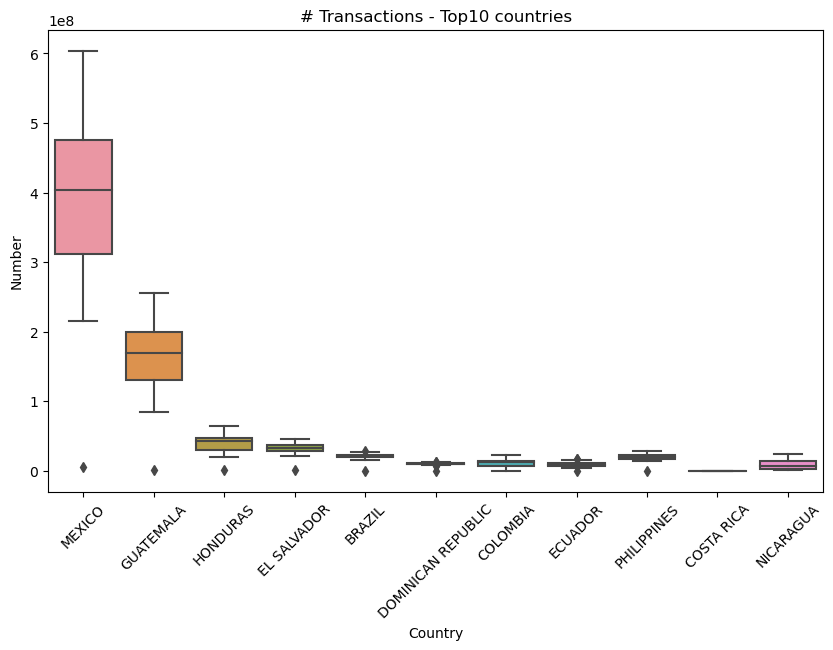

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot de los montos por país
plt.figure(figsize=(10, 6))
sns.boxplot(x='country', y='amount', data=top_10_countries)
plt.xlabel('Country')
plt.ylabel('Number')
plt.title('# Transactions - Top10 countries')
plt.xticks(rotation=45)
plt.show()

#### Tendencia temporal y estacionalidades

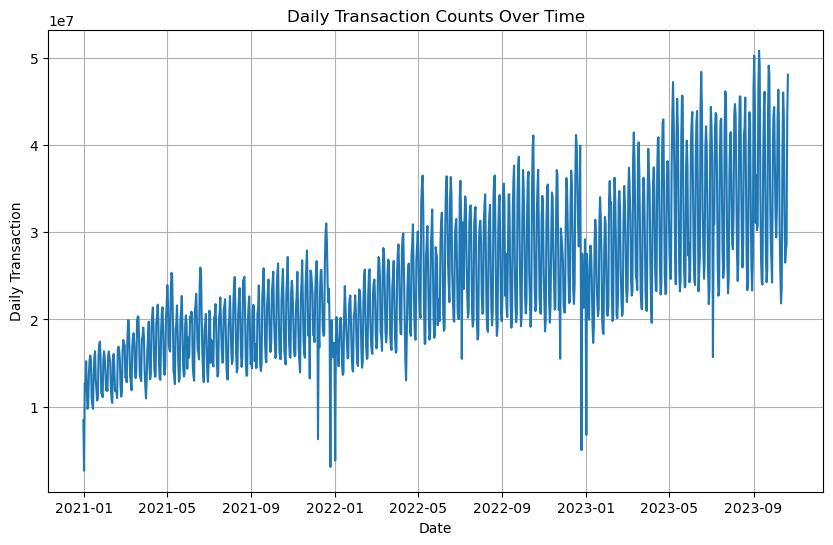

In [23]:
# Agrupar por fecha y calcular la suma de 'amount' para cada día
daily_amount = df.groupby('date')['amount'].sum()

# Gráfico de línea para la cantidad de transacciones diarias a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(daily_amount)
plt.title('Daily Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Transaction')
plt.grid(True)
plt.show()

In [24]:
daily_amount.head(20)

date
2020-12-31    8.465152e+06
2021-01-01    2.666703e+06
2021-01-02    1.266768e+07
2021-01-03    1.221146e+07
2021-01-04    1.521453e+07
2021-01-05    1.188763e+07
2021-01-06    9.759020e+06
2021-01-07    1.011663e+07
2021-01-08    1.369372e+07
2021-01-09    1.530039e+07
2021-01-10    1.587645e+07
2021-01-11    1.531943e+07
2021-01-12    1.107815e+07
2021-01-13    1.023898e+07
2021-01-14    9.750388e+06
2021-01-15    1.387317e+07
2021-01-16    1.577221e+07
2021-01-17    1.635807e+07
2021-01-18    1.309725e+07
2021-01-19    1.184319e+07
Name: amount, dtype: float64

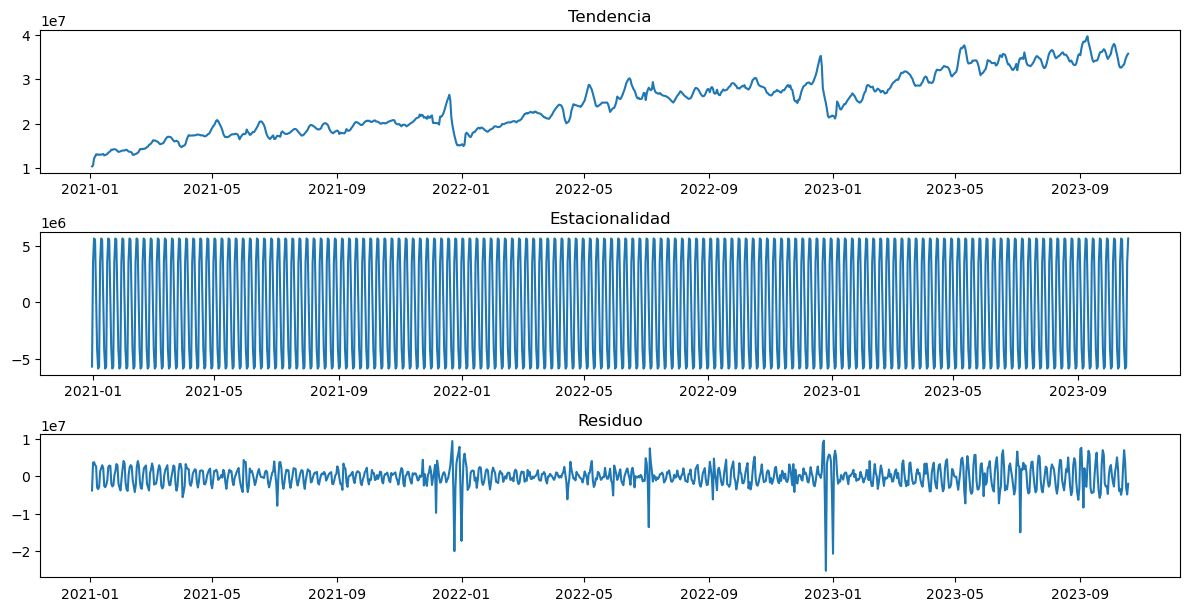

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal
decomposition = seasonal_decompose(daily_amount, model='additive')

# Gráficos para cada componente (tendencia, estacionalidad y residuo)
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuo')

plt.tight_layout()
plt.show()

In [26]:
# Extract the trend, seasonality, and residual components

# Convert the decomposed components into DataFrames
trend_df = pd.DataFrame({'Trend': decomposition.trend})
seasonal_df = pd.DataFrame({'Seasonal': decomposition.seasonal})
residual_df = pd.DataFrame({'Residual': decomposition.resid})

In [27]:
decomposition_df = pd.concat([trend_df, seasonal_df, residual_df], axis=1)

In [28]:
decomposition_df.head(20)

,Trend,Seasonal,Residual
date,,,
2020-12-31,NaN,-5.689245e+06,NaN
2021-01-01,NaN,3.570855e+06,NaN
2021-01-02,NaN,5.667946e+06,NaN
2021-01-03,1.041031e+07,5.562446e+06,-3.761291e+06
2021-01-04,1.064624e+07,9.021759e+05,3.666116e+06
2021-01-05,1.222152e+07,-4.146088e+06,3.812191e+06
2021-01-06,1.259763e+07,-5.868089e+06,3.029482e+06
2021-01-07,1.312120e+07,-5.689245e+06,2.684677e+06
2021-01-08,1.313618e+07,3.570855e+06,-3.013312e+06


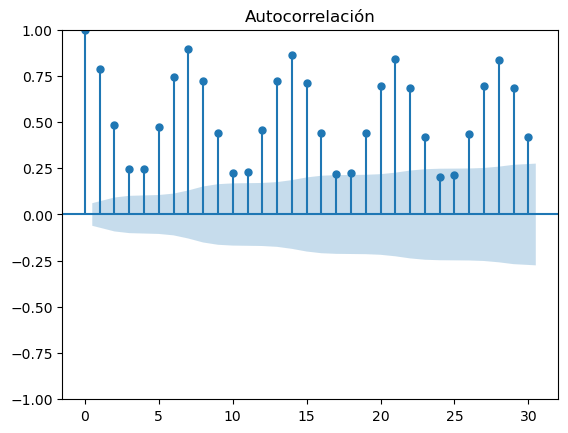

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


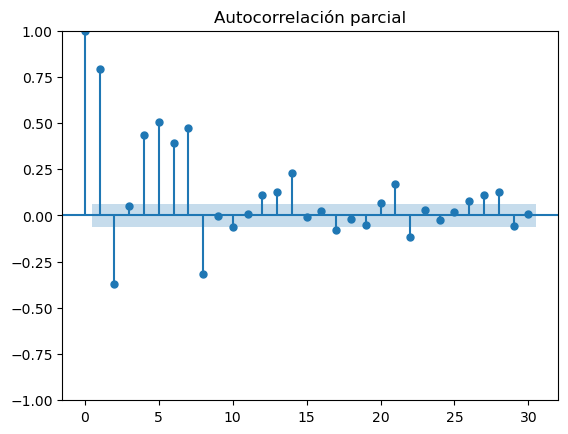

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelación
plot_acf(daily_amount, lags=30)
plt.title('Autocorrelación')
plt.show()

# Autocorrelación parcial
plot_pacf(daily_amount, lags=30)
plt.title('Autocorrelación parcial')
plt.show()

In [30]:
from statsmodels.tsa.stattools import acf, pacf

# Calcular autocorrelación y autocorrelación parcial
lags = 30
acf_vals = acf(daily_amount, nlags=lags)
pacf_vals = pacf(daily_amount, nlags=lags)

# Crear un DataFrame con los resultados
results = pd.DataFrame({'ACF': acf_vals, 'PACF': pacf_vals})
results.index.name = 'Lag'

results

,ACF,PACF
Lag,,
0,1.000000,1.000000
1,0.789547,0.790318
2,0.484282,-0.371271
3,0.247642,0.049219
4,0.246587,0.436655
5,0.473521,0.506224
6,0.744731,0.390518
7,0.897672,0.475194
8,0.722603,-0.316873


In [32]:
#Voy a achicar todo a Mexico, que representa el 55% del total
df2 = df[df['country'] == 'MEXICO']

In [33]:
df2 = df2.sort_values(by='date')

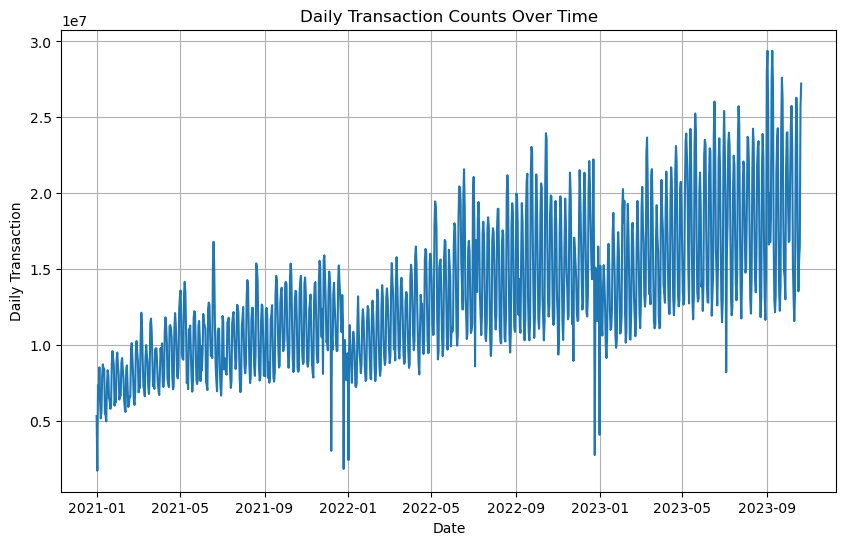

In [34]:
# Agrupar por fecha y calcular la suma de 'amount' para cada día
daily_amount2 = df2.groupby('date')['amount'].sum()

# Gráfico de línea para la cantidad de transacciones diarias a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(daily_amount2)
plt.title('Daily Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Transaction')
plt.grid(True)
plt.show()

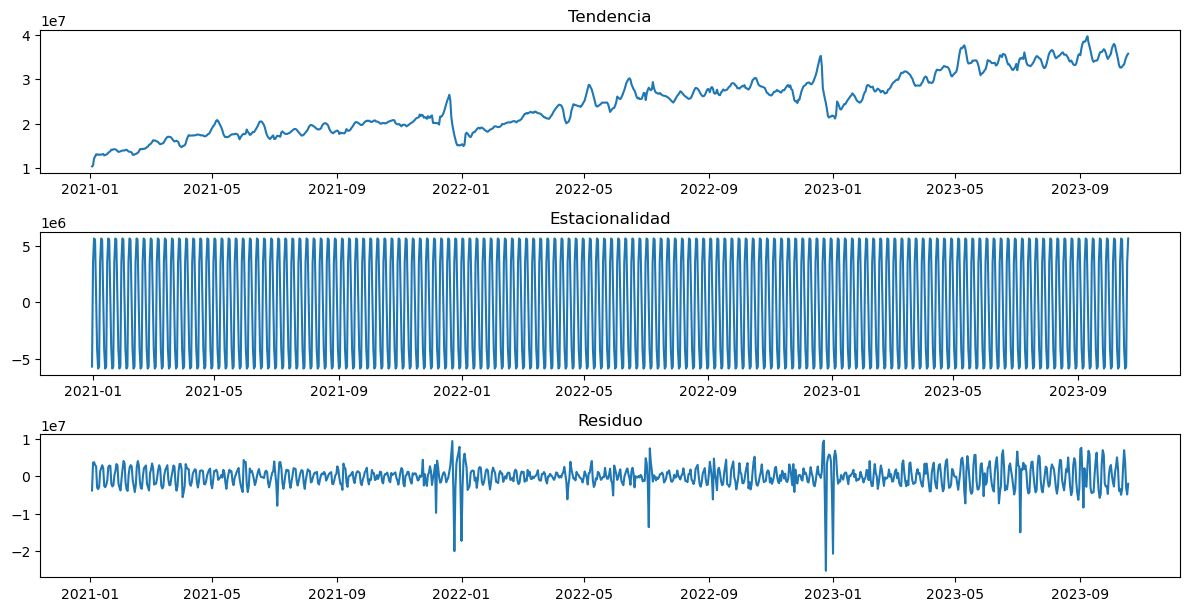

In [35]:
# Descomposición de la serie temporal de Mexico

decomposition2 = seasonal_decompose(daily_amount2, model='additive')

# Gráficos para cada componente (tendencia, estacionalidad y residuo)
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuo')

plt.tight_layout()
plt.show()

In [36]:
# Extract the trend, seasonality, and residual components

# Convert the decomposed components into DataFrames
trend_df2 = pd.DataFrame({'Trend': decomposition2.trend})
seasonal_df2 = pd.DataFrame({'Seasonal': decomposition2.seasonal})
residual_df2 = pd.DataFrame({'Residual': decomposition2.resid})

decomposition_df2 = pd.concat([trend_df2, seasonal_df2, residual_df2], axis=1)
decomposition_df2

,Trend,Seasonal,Residual
date,,,
2020-12-31,NaN,-2.815774e+06,NaN
2021-01-01,NaN,2.600444e+06,NaN
2021-01-02,NaN,3.666376e+06,NaN
2021-01-03,5.825994e+06,2.688900e+06,-2.085109e+06
2021-01-04,5.865279e+06,-1.329877e+05,2.784239e+06
...,...,...,...
2023-10-17,1.981662e+07,-2.667661e+06,-3.614494e+06
2023-10-18,1.995067e+07,-3.339297e+06,-1.013006e+06
2023-10-19,NaN,-2.815774e+06,NaN


In [37]:
decomposition_df

,Trend,Seasonal,Residual
date,,,
2020-12-31,NaN,-5.689245e+06,NaN
2021-01-01,NaN,3.570855e+06,NaN
2021-01-02,NaN,5.667946e+06,NaN
2021-01-03,1.041031e+07,5.562446e+06,-3.761291e+06
2021-01-04,1.064624e+07,9.021759e+05,3.666116e+06
...,...,...,...
2023-10-17,3.547110e+07,-4.146088e+06,-4.818045e+06
2023-10-18,3.576178e+07,-5.868089e+06,-1.985543e+06
2023-10-19,NaN,-5.689245e+06,NaN


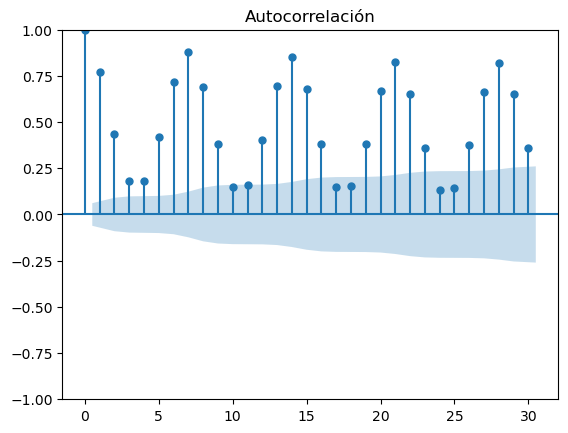

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


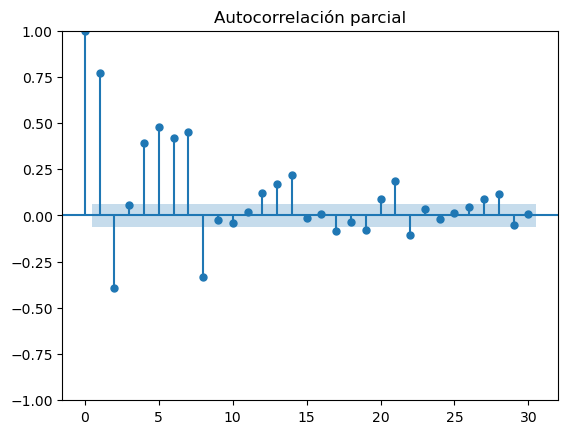

In [38]:
# Autocorrelación
plot_acf(daily_amount2, lags=30)
plt.title('Autocorrelación')
plt.show()

# Autocorrelación parcial
plot_pacf(daily_amount2, lags=30)
plt.title('Autocorrelación parcial')
plt.show()

In [39]:
# Calcular autocorrelación y autocorrelación parcial para Mexico
lags = 30

acf_vals2 = acf(daily_amount2, nlags=lags)
pacf_vals2 = pacf(daily_amount2, nlags=lags)

# Crear un DataFrame con los resultados
results = pd.DataFrame({'ACF': acf_vals2, 'PACF': pacf_vals2})
results.index.name = 'Lag'

results

,ACF,PACF
Lag,,
0,1.000000,1.000000
1,0.770195,0.770947
2,0.433677,-0.394032
3,0.182683,0.058374
4,0.180038,0.389740
5,0.419351,0.477351
6,0.716624,0.418856
7,0.881874,0.453829
8,0.691798,-0.331550


#### LSTM para Mexico

In [40]:
#pip install tensorflow

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

2023-12-14 01:14:47.336343: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 01:14:47.381918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 01:14:47.381958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 01:14:47.383174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 01:14:47.390834: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 01:14:47.391426: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [42]:
# Escala 'amount' entre -1 y 1
#scaler2 = MinMaxScaler()
#df2['amount'] = scaler2.fit_transform(df2['amount'].values.reshape(-1, 1))

In [43]:
df

,payer,country,date,amount
0,BANCO DE CREDITO DEL PERU - BCP (UT),PERU,2021-12-05,23150.00
1,GME,NEPAL,2023-08-11,6486.00
2,COOPERATIVA FRONTERIZA (UT),HONDURAS,2023-09-23,33632.00
3,DAVIVIENDA - HONDURAS (BTS),HONDURAS,2023-09-24,14824.50
4,GLOBAL ENVIOS,ECUADOR,2022-03-29,29563.00
...,...,...,...,...
103721,PROMERICA (GUA),GUATEMALA,2021-07-13,10855.00
103722,WALMART (UT),MEXICO,2021-07-15,138935.54
103723,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2021-07-15,22438.00
103724,CUSCA (CITI - RECIBA NETWORKS),EL SALVADOR,2023-06-01,239445.00


In [44]:
df2

,payer,country,date,amount
52955,INPAMEX - INSTANT PAY DE MEXICO,MEXICO,2020-12-31,32200.29
103145,BANORTE (UT),MEXICO,2020-12-31,169429.93
59524,7 ELEVEN (UT),MEXICO,2020-12-31,100.00
33125,WALDOS (APPRIZA),MEXICO,2020-12-31,534.33
4547,ENVIOS CON CLABE (APPRIZA),MEXICO,2020-12-31,147611.12
...,...,...,...,...
101493,GIROSMEX,MEXICO,2023-10-21,60872.22
4886,BBVA - BANCOMER (BTS),MEXICO,2023-10-21,1132658.96
84390,AIRPAK,MEXICO,2023-10-21,149525.30
80303,EMPENOS DEL SUR (ANTERIOR BALSAS),MEXICO,2023-10-21,28394.89


In [46]:
# PRueba de Dickey-Fuller > Para validar si la serie es estacionaria

from statsmodels.tsa.stattools import adfuller

# Realizar la prueba ADF en la serie 'amount' de tu DataFrame 'df'
result2 = adfuller(df2['amount'])

# Mostrar los resultados
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])
print('Critical Values:')
for key, value in result2[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -13.71917157924098
p-value: 1.1969015272814005e-25
Critical Values:
	1%: -3.4306529075829726
	5%: -2.8616738750491466
	10%: -2.5668412579362005


Con valores normalizados, ADF es -13.48 aproximadamente, y el p-valor es casi cero (notar que es un nro elevado a -25). 
Sin escalar, ADF es -13,72 y el p-valor casi cero.
Podriamso rechazar la hipótesis nula de que la serie temporal tiene raíz unitaria, lo que implica que la serie si es estacionaria

In [47]:
df2

,payer,country,date,amount
52955,INPAMEX - INSTANT PAY DE MEXICO,MEXICO,2020-12-31,32200.29
103145,BANORTE (UT),MEXICO,2020-12-31,169429.93
59524,7 ELEVEN (UT),MEXICO,2020-12-31,100.00
33125,WALDOS (APPRIZA),MEXICO,2020-12-31,534.33
4547,ENVIOS CON CLABE (APPRIZA),MEXICO,2020-12-31,147611.12
...,...,...,...,...
101493,GIROSMEX,MEXICO,2023-10-21,60872.22
4886,BBVA - BANCOMER (BTS),MEXICO,2023-10-21,1132658.96
84390,AIRPAK,MEXICO,2023-10-21,149525.30
80303,EMPENOS DEL SUR (ANTERIOR BALSAS),MEXICO,2023-10-21,28394.89


In [48]:
df2.reset_index(drop=True, inplace=True)

In [49]:
df2 = df2.sort_values('date')

In [50]:
sequence_length = 10  # 10 pasos temporales consecutivos para predecir el siguiente valor (siguiente dia)

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

X, y = create_sequences(df2['amount'], sequence_length)

In [51]:
len(X), len(y)

(21628, 21628)

In [52]:
# SEPARO LOS DATOS
# 80% de los datos para entrenamiento
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [53]:
X_train

array([[3.22002900e+04, 9.90416500e+04, 1.10668980e+05, ...,
        1.50000000e+02, 4.20000000e+02, 2.81617360e+05],
       [9.90416500e+04, 1.10668980e+05, 1.62130000e+04, ...,
        4.20000000e+02, 2.81617360e+05, 3.46794000e+04],
       [1.10668980e+05, 1.62130000e+04, 1.19959800e+04, ...,
        2.81617360e+05, 3.46794000e+04, 2.05230000e+04],
       ...,
       [2.67199460e+05, 6.51617900e+05, 5.68931400e+04, ...,
        8.34860360e+06, 2.12000000e+03, 8.50546310e+05],
       [6.51617900e+05, 5.68931400e+04, 2.45558600e+04, ...,
        2.12000000e+03, 8.50546310e+05, 6.12582240e+05],
       [5.68931400e+04, 2.45558600e+04, 9.94324300e+04, ...,
        8.50546310e+05, 6.12582240e+05, 4.73554914e+06]])

In [54]:
# Remodelar los datos para LSTM: (número de muestras, número de pasos de tiempo, número de características)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [55]:
# Modelo LSTM
model2 = Sequential()

model2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# La primera capa LSTM tiene units=50, lo que significa que tiene 50 unidades de memoria LSTM. 
# Esta capa se establece en return_sequences=True > se espera una secuencia completa de salida para cada paso de tiempo

model2.add(LSTM(units=50))
# La segunda capa LSTM también tiene units=50 y está configurada de manera predeterminada para no devolver secuencias (return_sequences se omite, lo que significa que está en falso por defecto). 
# Esta capa solo devolverá la salida al final de la secuencia temporal.

model2.add(Dense(units=1))
# Capa densa. units=1 >  que representa la capa de salida con una sola unidad, por ahora ya estamos prediciendo un solo valor (la cantidad de transacciones 'amount').

In [56]:
# Compilar el modelo
model2.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
# Entrenar el modelo
model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
541/541 [==============================] - 11s 14ms/step - loss: 2303439142912.0000 - val_loss: 5368234115072.0000
Epoch 2/10
541/541 [==============================] - 6s 12ms/step - loss: 2303408734208.0000 - val_loss: 5368186929152.0000
Epoch 3/10
541/541 [==============================] - 6s 12ms/step - loss: 2303378587648.0000 - val_loss: 5368143937536.0000
Epoch 4/10
541/541 [==============================] - 7s 12ms/step - loss: 2303351062528.0000 - val_loss: 5368099897344.0000
Epoch 5/10
541/541 [==============================] - 6s 11ms/step - loss: 2303320391680.0000 - val_loss: 5368053235712.0000
Epoch 6/10
541/541 [==============================] - 7s 13ms/step - loss: 2303291817984.0000 - val_loss: 5368009719808.0000
Epoch 7/10
541/541 [==============================] - 6s 11ms/step - loss: 2303264030720.0000 - val_loss: 5367965155328.0000
Epoch 8/10
541/541 [==============================] - 7s 12ms/step - loss: 2303235981312.0000 - val_loss: 5367922163712.0000

Esos valores de pérdida extremadamente altos indican que el modelo no está aprendiendo correctamente

Voy a hacer algunos ajustes y escalar los valores de amount

In [67]:
df3 = df2.copy()

In [68]:
# Escala 'amount' entre -1 y 1
scaler3 = MinMaxScaler()
df3['amount'] = scaler3.fit_transform(df3['amount'].values.reshape(-1, 1))

In [71]:
df3 = df3.sort_values('date')

In [72]:
sequence_length = 10  # 10 pasos temporales consecutivos para predecir el siguiente valor (siguiente dia)

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

X, y = create_sequences(df3['amount'], sequence_length)

In [73]:
# SEPARO LOS DATOS
# 80% de los datos para entrenamiento
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [74]:
# Remodelar los datos para LSTM: (número de muestras, número de pasos de tiempo, número de características)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [76]:
# Primero, mismo Modelo pero ahora con valores escalados
model3 = Sequential()

model3.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# La primera capa LSTM tiene units=50, lo que significa que tiene 50 unidades de memoria LSTM. 
# Esta capa se establece en return_sequences=True > se espera una secuencia completa de salida para cada paso de tiempo

model3.add(LSTM(units=50))
# La segunda capa LSTM también tiene units=50 y está configurada de manera predeterminada para no devolver secuencias (return_sequences se omite, lo que significa que está en falso por defecto). 
# Esta capa solo devolverá la salida al final de la secuencia temporal.

model3.add(Dense(units=1))
# Capa densa. units=1 >  que representa la capa de salida con una sola unidad, por ahora ya estamos prediciendo un solo valor (la cantidad de transacciones 'amount').

In [77]:
# Compilar el modelo
model3.compile(optimizer='adam', loss='mean_squared_error')

In [78]:
# Entrenar el modelo
model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
541/541 [==============================] - 10s 13ms/step - loss: 0.0099 - val_loss: 0.0231
Epoch 2/10
541/541 [==============================] - 6s 11ms/step - loss: 0.0097 - val_loss: 0.0232
Epoch 3/10
541/541 [==============================] - 7s 13ms/step - loss: 0.0097 - val_loss: 0.0228
Epoch 4/10
541/541 [==============================] - 7s 13ms/step - loss: 0.0097 - val_loss: 0.0228
Epoch 5/10
541/541 [==============================] - 8s 14ms/step - loss: 0.0097 - val_loss: 0.0231
Epoch 6/10
541/541 [==============================] - 6s 11ms/step - loss: 0.0097 - val_loss: 0.0232
Epoch 7/10
541/541 [==============================] - 6s 12ms/step - loss: 0.0097 - val_loss: 0.0228
Epoch 8/10
541/541 [==============================] - 7s 12ms/step - loss: 0.0097 - val_loss: 0.0233
Epoch 9/10
541/541 [==============================] - 7s 12ms/step - loss: 0.0097 - val_loss: 0.0231
Epoch 10/10
541/541 [==============================] - 6s 12ms/step - loss: 0.0097 - val_l

In [81]:
from keras.optimizers import Adagrad

# Pruebo con optimizador Adagrad y aumento el nro de epochs
model4 = Sequential()
model4.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model4.add(LSTM(units=50))
model4.add(Dense(units=1))
model4.compile(optimizer=Adagrad(), loss='mean_squared_error')

# Entrenamiento con tamaño de lote y número de épocas ajustados
history = model4.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
271/271 [==============================] - 7s 16ms/step - loss: 0.0102 - val_loss: 0.0236
Epoch 2/20
271/271 [==============================] - 4s 13ms/step - loss: 0.0100 - val_loss: 0.0236
Epoch 3/20
271/271 [==============================] - 4s 14ms/step - loss: 0.0100 - val_loss: 0.0235
Epoch 4/20
271/271 [==============================] - 4s 14ms/step - loss: 0.0100 - val_loss: 0.0236
Epoch 5/20
271/271 [==============================] - 4s 14ms/step - loss: 0.0100 - val_loss: 0.0236
Epoch 6/20
271/271 [==============================] - 4s 13ms/step - loss: 0.0100 - val_loss: 0.0236
Epoch 7/20
271/271 [==============================] - 4s 15ms/step - loss: 0.0100 - val_loss: 0.0236
Epoch 8/20
271/271 [==============================] - 4s 15ms/step - loss: 0.0100 - val_loss: 0.0235
Epoch 9/20
271/271 [==============================] - 4s 15ms/step - loss: 0.0100 - val_loss: 0.0236
Epoch 10/20
271/271 [==============================] - 4s 14ms/step - loss: 0.0100 - val_lo

In [83]:
model5 = Sequential() #Agrego una capa

model5.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model5.add(LSTM(units=50, return_sequences=True))
model5.add(LSTM(units=50))
model5.add(Dense(units=1))

model5.compile(optimizer='adam', loss='mean_squared_error')


In [85]:
#Entrenamiento con tamaño de lote y número de épocas ajustados
history = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
541/541 [==============================] - 16s 19ms/step - loss: 0.0100 - val_loss: 0.0230
Epoch 2/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0098 - val_loss: 0.0230
Epoch 3/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0097 - val_loss: 0.0229
Epoch 4/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0097 - val_loss: 0.0232
Epoch 5/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0097 - val_loss: 0.0231
Epoch 6/10
541/541 [==============================] - 10s 19ms/step - loss: 0.0097 - val_loss: 0.0229
Epoch 7/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0097 - val_loss: 0.0236
Epoch 8/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0097 - val_loss: 0.0228
Epoch 9/10
541/541 [==============================] - 10s 19ms/step - loss: 0.0097 - val_loss: 0.0230
Epoch 10/10
541/541 [==============================] - 9s 16ms/step - loss: 0.0097

In [87]:
# Vario learning rate

learning_rate = 0.01  # Tu valor deseado para la tasa de aprendizaje

optimizer = Adagrad(learning_rate=learning_rate)
model5.compile(optimizer=optimizer, loss='mean_squared_error')

In [88]:
model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
541/541 [==============================] - 16s 21ms/step - loss: 0.0097 - val_loss: 0.0230
Epoch 2/10
541/541 [==============================] - 9s 17ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 3/10
541/541 [==============================] - 9s 17ms/step - loss: 0.0096 - val_loss: 0.0229
Epoch 4/10
541/541 [==============================] - 9s 17ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 5/10
541/541 [==============================] - 9s 17ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 6/10
541/541 [==============================] - 9s 17ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 7/10
541/541 [==============================] - 11s 20ms/step - loss: 0.0096 - val_loss: 0.0229
Epoch 8/10
541/541 [==============================] - 9s 17ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 9/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 10/10
541/541 [==============================] - 10s 18ms/step - loss: 0.0096 - va

La funcion de perdida sigue casi constante, el modelo sigue sin ajustar